In [1]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2020-03-12 16:11:17--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 2607:f8b0:4001:c0e::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   151MB/s    in 0.6s    

2020-03-12 16:11:17 (151 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [0]:
#load the inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#initiate base model
base_model=InceptionV3(input_shape=(150,150,3),
                       include_top=False,
                       weights=None)
path_weights='/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#load the trained feature weights
base_model.load_weights(path_weights)
#freeze the layers
for layer in base_model.layers:
  layer.trainable=False

In [5]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1_188 (Bat (None, 74, 74, 32)   96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 74, 74, 32)   0           batch_normalization_v1_188[0][0] 
_______________________________________________________________________________________

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model
#we want up to the layer mixed 7
last_layer=base_model.get_layer('mixed7')
print(last_layer.output_shape)
output_layer=last_layer.output

(None, 7, 7, 768)


In [0]:
#flatten the layer
x=layers.Flatten()(output_layer)
#add a hidden layer
x=layers.Dense(1024,activation='relu')(x)
#dropout
x=layers.Dropout(0.2)(x)
#add last layer
x=layers.Dense(1,activation='sigmoid')(x)

In [0]:
#instantiate call back to stop training when acc of 99.9% is reached
import tensorflow as tf
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('acc')>0.999):
      print('\nReached accuracy of 99.9%')
      self.model.stop_training=True

stop=myCallback()

In [0]:
#build the model from the input and the x layers
from tensorflow.keras.optimizers import RMSprop
model=Model(base_model.input,x)
model.compile(optimizer=RMSprop(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['acc'])

In [18]:
# Get the Horse or Human dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -O /tmp/horse-or-human.zip

# Get the Horse or Human Validation dataset
!wget --no-check-certificate https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -O /tmp/validation-horse-or-human.zip 

--2020-03-12 16:25:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.111.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.111.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   161MB/s    in 0.9s    

2020-03-12 16:25:16 (161 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2020-03-12 16:25:18--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.202.128, 2607:f8b0:4001:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application

In [0]:
import zipfile
import os

train_path='/tmp/horse-or-human.zip'
test_path='/tmp/validation-horse-or-human.zip'
#extract train dataset
zip_ref=zipfile.ZipFile(train_path,'r')
zip_ref.extractall('/tmp/train')
zip_ref.close()
#extract test data set
zip_ref=zipfile.ZipFile(test_path,'r')
zip_ref.extractall('/tmp/test')
zip_ref.close()





In [26]:
train_dir='/tmp/train'
test_dir='/tmp/test'

train_horse_dir='/tmp/train/horses'
train_human_dir='/tmp/train/humans'

test_horse_dir='/tmp/test/horses'
test_human_dir='/tmp/test/humans'

print(len(os.listdir(train_human_dir)))
print(len(os.listdir(train_horse_dir)))
print(len(os.listdir(test_human_dir)))
print(len(os.listdir(test_horse_dir)))


527
500
128
128


In [47]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen=ImageDataGenerator(
    rescale=1.0/255.0,
)

train_generator=train_gen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_gen=ImageDataGenerator(rescale=1.0/255.0)
test_generator=test_gen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)



Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [48]:
# fires, and stops training at 99.9% accuracy
# (It should take less than 100 epochs)
history=model.fit_generator(train_generator,steps_per_epoch=100,epochs=10,validation_data=test_generator,validation_steps=50,verbose=2,callbacks=[stop])


Epoch 1/10
100/100 - 211s - loss: 0.0064 - acc: 0.9980 - val_loss: 0.0331 - val_acc: 0.9960
Epoch 2/10

Reached accuracy of 99.9%
100/100 - 212s - loss: 2.1469e-04 - acc: 1.0000 - val_loss: 0.0352 - val_acc: 0.9970


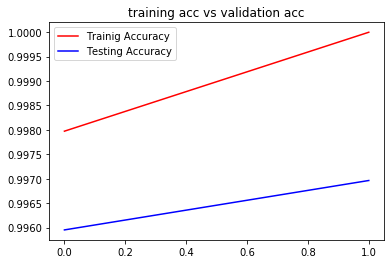

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [49]:
import matplotlib.pyplot as plt

acc=history.history['acc']
val_acc=history.history['val_acc']


epochs=range(len(acc))
plt.plot(epochs,acc,'r',label='Trainig Accuracy')
plt.plot(epochs,val_acc,'b',label='Testing Accuracy')

plt.title('training acc vs validation acc')
plt.legend(loc=0)
plt.show()
plt.figure()


In [50]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")

Saving white-horse.jpg to white-horse (4).jpg
[1.]
white-horse.jpg is a human
